**#CoronaVirusPandemic using snscrape**

In this notebook, we will be analysing sentiments for Twitter hashtags #CoronaVirusPandemic, #COVIDworkfromhome and #zoomuniversity to understand public sentiments around the pandemic and lockdown restrictions. 

We will first try to find sentiments around the Twitter hashtag #CoronaVirusPandemic. For this, let us first install the necessary packages on python 

In [ ]:
!pip install snscrape

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud

**Step 1: Get the Tweets**

Here we are getting the Tweets related to the Twitter hashtag #coronavirus

In [ ]:
import snscrape.base
import snscrape.modules.twitter as sntwitter
import pandas as pd
# Setting variables to be used below
maxTweets = 100000
# Creating list to append tweet data to
tweets_corona = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#CoronaVirusPandemic since:2020-03-31 until:2021-03-31 lang:en').get_items()):
  if i>maxTweets:
    break
  tweets_corona.append([tweet.date, tweet.content])
# Creating a dataframe from the tweets list above
corona_df = pd.DataFrame(tweets_corona, columns=['DateTime','Text'])
# Display first 5 entries from dataframe
corona_df.head()

,DateTime,Text
0,2021-03-30 23:54:20+00:00,#ThisIsAustralia Find out when you're eligible...
1,2021-03-30 23:30:01+00:00,"“It’s just hard for me to understand... I, in ..."
2,2021-03-30 23:29:51+00:00,#India #CoronaVirus #COVID19 #CoronavirusPande...
3,2021-03-30 23:09:26+00:00,10 new cases in French Polynesia \n\n[0:09 GMT...
4,2021-03-30 23:03:57+00:00,121 new cases and 7 new deaths in Nigeria \n\n...


We want to specifically test the sentiments around 'lockdown' and 'vaccination' since these are two key discussions around the COVID-19 pandemic. We want to understand how positive/negative are people towards these two.

In [ ]:
lockdown_refs= ['lockdown', 'Lock Down', 'lock down', 'restrictions']  #words that refer to lockdown
vaccine_refs= ['vaccine', 'astrazeneca', 'pfizer', 'vaccination']      #words that refer to vaccination

Now, we are creating two more columns in our dataframe with lockdown and vaccine references. Going further, we will be using these columns to do sentiment analysis for lockdown and vaccination separately

In [ ]:
def identify_subject(tweet, refs):
  flag =0 
  for ref in refs: 
    if tweet.find(ref)!=-1:
      flag =1
    return flag

corona_df['lockdown']= corona_df['Text'].apply(lambda x: identify_subject(x,lockdown_refs))
corona_df['Vaccine']= corona_df['Text'].apply(lambda x: identify_subject(x, vaccine_refs))

In [ ]:
corona_df.head()

,DateTime,Text,lockdown,Vaccine
0,2021-03-30 23:54:20+00:00,#ThisIsAustralia Find out when you're eligible...,0,1
1,2021-03-30 23:30:01+00:00,"“It’s just hard for me to understand... I, in ...",0,0
2,2021-03-30 23:29:51+00:00,#India #CoronaVirus #COVID19 #CoronavirusPande...,0,0
3,2021-03-30 23:09:26+00:00,10 new cases in French Polynesia \n\n[0:09 GMT...,0,0
4,2021-03-30 23:03:57+00:00,121 new cases and 7 new deaths in Nigeria \n\n...,0,0


**Step 2: Data Pre-Processing**

We will download the Natural Language Toolkit (nltk packages) to remove stopwords and custom stop words (set by us) from the text and make it cleaner

NLTK is a very popular natural language processing library consisting of a large number of tools to analyse texts. Here we are using the stopwords feature which consists of a large number of stopwords in English- words that do not have a significant contribution to the meaning of the text or the message it wants to convey. We will also use TextBlob from NLTK

In [ ]:
import nltk 
from nltk.corpus import stopwords

from textblob import Word, TextBlob

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words= stopwords.words('english')
custom_stopwords2= ['RT', '#coronavirus', 'https', 'co']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess_tweets(tweet, custom_stopwords1):
    processed_tweet = tweet
    processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords2)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

corona_df['Processed Tweet'] = corona_df['Text'].apply(lambda x: preprocess_tweets(x, custom_stopwords2))
corona_df.head()

,DateTime,Text,lockdown,Vaccine,Processed Tweet
0,2021-03-30 23:54:20+00:00,#ThisIsAustralia Find out when you're eligible...,0,1,#ThisIsAustralia Find eligible receive COVID-1...
1,2021-03-30 23:30:01+00:00,"“It’s just hard for me to understand... I, in ...",0,0,"“It’s hard understand... I, sense, kind feel s..."
2,2021-03-30 23:29:51+00:00,#India #CoronaVirus #COVID19 #CoronavirusPande...,0,0,#India #CoronaVirus #COVID19 #CoronavirusPande...
3,2021-03-30 23:09:26+00:00,10 new cases in French Polynesia \n\n[0:09 GMT...,0,0,10 new case French Polynesia [0:09 GMT] #Coron...
4,2021-03-30 23:03:57+00:00,121 new cases and 7 new deaths in Nigeria \n\n...,0,0,121 new case 7 new death Nigeria [0:03 GMT] #C...


Lemmatization is the process of taking a word and reducing it to its base form. For example, if you have a word 'debates' then lemmatization reduces it to its base form 'debate'. 

In [ ]:
import re
def cleantxt(text):
  text= re.sub(r'@[A-Za-z0-9]+', ' ', text) #remove @ mentions 
  text= re.sub(r'https?:\/\/\S+', ' ', text) #remove hyper links

  return text

corona_df['Processed Tweet']=corona_df['Processed Tweet'].apply(cleantxt)

corona_df.head()

,DateTime,Text,lockdown,Vaccine,Processed Tweet
0,2021-03-30 23:54:20+00:00,#ThisIsAustralia Find out when you're eligible...,0,1,#ThisIsAustralia Find eligible receive COVID-1...
1,2021-03-30 23:30:01+00:00,"“It’s just hard for me to understand... I, in ...",0,0,"“It’s hard understand... I, sense, kind feel s..."
2,2021-03-30 23:29:51+00:00,#India #CoronaVirus #COVID19 #CoronavirusPande...,0,0,#India #CoronaVirus #COVID19 #CoronavirusPande...
3,2021-03-30 23:09:26+00:00,10 new cases in French Polynesia \n\n[0:09 GMT...,0,0,10 new case French Polynesia [0:09 GMT] #Coron...
4,2021-03-30 23:03:57+00:00,121 new cases and 7 new deaths in Nigeria \n\n...,0,0,121 new case 7 new death Nigeria [0:03 GMT] #C...


**Step 3: Calculate Sentiment**

From our sentiment analysis we are going to get 2 values- polarity and subjectivity. 

**Polarity** helps us to understand how positive or negative a sentiment is. It ranges between -1 and +1, the closer the polarity is to +1, the more positive the message. **Subjectivity** explains how much a piece of text depends on emotions. It ranges from a score of 0 to 1 (0 being less subjective). 

In [ ]:
corona_df['polarity'] = corona_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
corona_df['subjectivity'] = corona_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])
corona_df.head()

,DateTime,Text,lockdown,Vaccine,Processed Tweet,polarity,subjectivity
0,2021-03-30 23:54:20+00:00,#ThisIsAustralia Find out when you're eligible...,0,1,#ThisIsAustralia Find eligible receive COVID-1...,0.000000,0.000000
1,2021-03-30 23:30:01+00:00,"“It’s just hard for me to understand... I, in ...",0,0,"“It’s hard understand... I, sense, kind feel s...",-0.063889,0.813889
2,2021-03-30 23:29:51+00:00,#India #CoronaVirus #COVID19 #CoronavirusPande...,0,0,#India #CoronaVirus #COVID19 #CoronavirusPande...,0.250000,0.250000
3,2021-03-30 23:09:26+00:00,10 new cases in French Polynesia \n\n[0:09 GMT...,0,0,10 new case French Polynesia [0:09 GMT] #Coron...,0.068182,0.227273
4,2021-03-30 23:03:57+00:00,121 new cases and 7 new deaths in Nigeria \n\n...,0,0,121 new case 7 new death Nigeria [0:03 GMT] #C...,0.136364,0.454545


Let us now calculate topic-specific aggregate statistics for polarity and subjectivity 

In [ ]:
import numpy as np
display(corona_df[corona_df['lockdown']==1][['lockdown','polarity','subjectivity']].groupby('lockdown').agg([np.mean, np.max, np.min, np.median]))
corona_df[corona_df['Vaccine']==1][['Vaccine','polarity','subjectivity']].groupby('Vaccine').agg([np.mean, np.max, np.min, np.median])

polarity                  subjectivity                    
              mean amax amin median         mean amax amin    median
lockdown                                                            
1         0.055205  1.0 -1.0    0.0     0.340459  1.0  0.0  0.366667

polarity                     subjectivity                    
             mean amax amin    median         mean amax amin    median
Vaccine                                                               
1        0.102739  1.0 -1.0  0.055714     0.347823  1.0  0.0  0.381818

From the above tables we can see that the mean polarity for 'lockdown' is 0.055205, meaning that the overall sentiment around lockdown is slighly positive. Even though the lockdown restricions had a severe impact on unemployment, economy and mental health, people still associate lockdown with positive emotions overall. The mean subjectivity for lockdown is 0.340459 meaning that when talking about lockdowns, people share more news and facts rather than personal opinions and emotions.  

For 'vaccine' the mean polarity is 0.102739 meaning that the overall sentiment for it slightly positive. People are mostly positive about vaccinations despite the recent concerns over their side-effects and efficiency. People are more positive about the vaccinations than lockdown, perhaps because the world sees vaccines as a way out of the pandemic. The mean subjectivity for vaccine is 0.347823 meaning that people are still very objective (fact-based) when discussing vaccinations. 

**Step 4: Visualise Sentiments**

We will first make topic-specific moving average dataframe. We using the rolling feature of pandas dataframe to create a 10 tweet moving average. We will only start calculating this moving average if we have a minimum of 3 periods. 

In [ ]:
CORONA = corona_df[['DateTime', 'polarity']]
CORONA = corona_df.sort_values(by='DateTime', ascending=True)
CORONA['MA Polarity'] = CORONA.polarity.rolling(10,min_periods=2).mean()

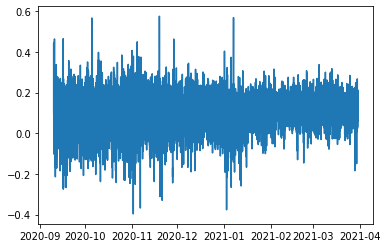

In [ ]:
from matplotlib import pyplot as plt
plt.plot(CORONA['DateTime'], CORONA['MA Polarity'])

We are now going to plot the polarity for lockdowns and vaccines indisvidually and then compare between the two

In [ ]:
vaccine = corona_df[corona_df['Vaccine']==1][['DateTime', 'polarity']]
vaccine = vaccine.sort_values(by='DateTime', ascending=True)
vaccine['MA Polarity'] = vaccine.polarity.rolling(10, min_periods=3).mean()

lockdown = corona_df[corona_df['lockdown']==1][['DateTime', 'polarity']]
lockdown = lockdown.sort_values(by='DateTime', ascending=True)
lockdown['MA Polarity'] = lockdown.polarity.rolling(10, min_periods=3).mean()

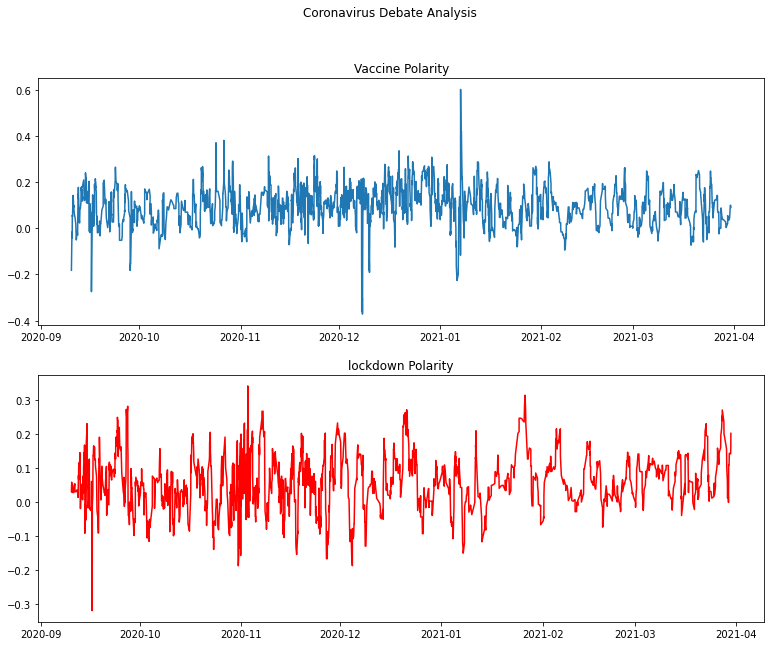

In [ ]:
repub = 'red'
demo = 'blue'
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

axes[0].plot(vaccine['DateTime'], vaccine['MA Polarity'])
axes[0].set_title("\n".join(["Vaccine Polarity"]))
axes[1].plot(lockdown['DateTime'], lockdown['MA Polarity'], color='red')
axes[1].set_title("\n".join(["lockdown Polarity"]))

fig.suptitle("\n".join(["Coronavirus Debate Analysis"]), y=0.98)

plt.show()

Finally, we will create a wordcloud to see the most common words in this discussion

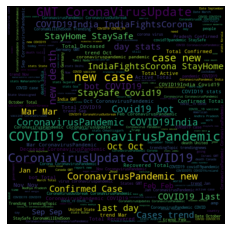

In [ ]:
all_words=' '.join( [twts for twts in corona_df['Processed Tweet'] ])
wordCloud = WordCloud(width =500, height= 500, random_state=21, max_font_size=119).generate(all_words)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Work from Home using snscrape**

In [ ]:
import snscrape.base
import snscrape.modules.twitter as sntwitter
import pandas as pd
# Setting variables to be used below
maxTweets = 100000
# Creating list to append tweet data to
tweets_wfh = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#COVIDWorkFromHome since:2020-03-25 until:2021-04-01').get_items()):
  if i>maxTweets:
    break
  tweets_wfh.append([tweet.date, tweet.content])
# Creating a dataframe from the tweets list above
wfh_df = pd.DataFrame(tweets_wfh, columns=['DateTime','Text'])
# Display first 5 entries from dataframe
wfh_df.head()

,DateTime,Text
0,2021-03-25 21:13:52+00:00,@marklewismd The most appropriate gif for #cov...
1,2021-01-20 15:57:24+00:00,@GreyRoots may be closed but the work continue...
2,2021-01-15 00:15:58+00:00,It's been an exhausting week at work. I think ...
3,2021-01-08 17:55:53+00:00,Motivational pen and ink treats as I brace mys...
4,2020-12-14 21:30:28+00:00,Do you ever get the feeling that someone is lo...


In [ ]:
custom_stopwords1= ['RT', '#WorkFromHome', '#workfromhome', '#wfh', '#Workfromhome']

In [ ]:
def preprocess_tweets(tweet, custom_stopwords1):
    processed_tweet = tweet
    processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords1)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

wfh_df['Processed Tweet'] = wfh_df['Text'].apply(lambda x: preprocess_tweets(x, custom_stopwords1))
wfh_df.head()

,DateTime,Text,Processed Tweet
0,2021-03-25 21:13:52+00:00,@marklewismd The most appropriate gif for #cov...,@marklewismd The appropriate gif #covidworkfro...
1,2021-01-20 15:57:24+00:00,@GreyRoots may be closed but the work continue...,@GreyRoots may closed work continues! Celebrat...
2,2021-01-15 00:15:58+00:00,It's been an exhausting week at work. I think ...,It's exhausting week work. I think desk chair ...
3,2021-01-08 17:55:53+00:00,Motivational pen and ink treats as I brace mys...,Motivational pen ink treat I brace #teams #zoo...
4,2020-12-14 21:30:28+00:00,Do you ever get the feeling that someone is lo...,Do ever get feeling someone looking shoulder h...


In [ ]:
import re
def cleantxt(text):
  text= re.sub(r'@[A-Za-z0-9]+', ' ', text) #remove @ mentions 
  text= re.sub(r'https?:\/\/\S+', ' ', text) #remove hyper links

  return text

wfh_df['Processed Tweet']=wfh_df['Processed Tweet'].apply(cleantxt)

wfh_df.head()

,DateTime,Text,Processed Tweet
0,2021-03-25 21:13:52+00:00,@marklewismd The most appropriate gif for #cov...,The appropriate gif #covidworkfromhome
1,2021-01-20 15:57:24+00:00,@GreyRoots may be closed but the work continue...,may closed work continues! Celebrating #Muse...
2,2021-01-15 00:15:58+00:00,It's been an exhausting week at work. I think ...,It's exhausting week work. I think desk chair ...
3,2021-01-08 17:55:53+00:00,Motivational pen and ink treats as I brace mys...,Motivational pen ink treat I brace #teams #zoo...
4,2020-12-14 21:30:28+00:00,Do you ever get the feeling that someone is lo...,Do ever get feeling someone looking shoulder h...


In [ ]:
wfh_df['polarity'] = wfh_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
wfh_df['subjectivity'] = wfh_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])
wfh_df.head()

,DateTime,Text,Processed Tweet,polarity,subjectivity
0,2021-03-25 21:13:52+00:00,@marklewismd The most appropriate gif for #cov...,The appropriate gif #covidworkfromhome,0.5000,0.500000
1,2021-01-20 15:57:24+00:00,@GreyRoots may be closed but the work continue...,may closed work continues! Celebrating #Muse...,-0.0625,0.050000
2,2021-01-15 00:15:58+00:00,It's been an exhausting week at work. I think ...,It's exhausting week work. I think desk chair ...,0.0000,0.433333
3,2021-01-08 17:55:53+00:00,Motivational pen and ink treats as I brace mys...,Motivational pen ink treat I brace #teams #zoo...,0.2000,0.200000
4,2020-12-14 21:30:28+00:00,Do you ever get the feeling that someone is lo...,Do ever get feeling someone looking shoulder h...,0.0000,0.000000


In [ ]:
import numpy as np
wfh_df[['polarity','subjectivity']].agg([np.mean, np.max, np.min, np.median])

,polarity,subjectivity
mean,0.025042,0.321748
amax,1.000000,1.000000
amin,-0.976562,0.000000
median,0.000000,0.312500


In [ ]:
WFH = wfh_df[['DateTime', 'polarity']]
WFH = wfh_df.sort_values(by='DateTime', ascending=True)
WFH['MA Polarity'] = WFH.polarity.rolling(10, min_periods=3).mean()

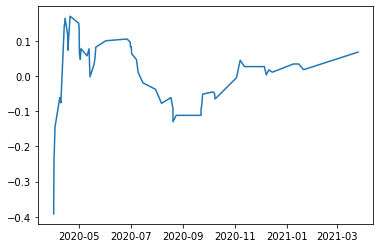

In [ ]:
from matplotlib import pyplot as plt
plt.plot(WFH['DateTime'], WFH['MA Polarity'])

Wordcloud

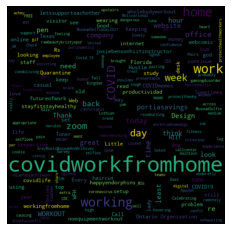

In [ ]:
all_words=' '.join( [twts for twts in wfh_df['Processed Tweet'] ])
wordCloud = WordCloud(width =500, height= 500, random_state=21, max_font_size=150).generate(all_words)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Online learning using snscrape**

In [ ]:
import snscrape.base
import snscrape.modules.twitter as sntwitter
import pandas as pd
# Setting variables to be used below
maxTweets = 100000
# Creating list to append tweet data to
tweets_list = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#zoomuniversity since:2020-03-31 until:2021-03-31').get_items()):
  if i>maxTweets:
    break
  tweets_list.append([tweet.date, tweet.content])
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['DateTime','Text'])
# Display first 5 entries from dataframe
tweets_df.head()

,DateTime,Text
0,2021-03-30 19:20:09+00:00,I never thought my goal would be to just get a...
1,2021-03-30 16:11:08+00:00,03/30/2021 - Still Not the Norm by Meredith Bo...
2,2021-03-30 15:49:04+00:00,These online class really do give you an aneur...
3,2021-03-30 15:44:07+00:00,Today was a good start to Tuesday in Reporting...
4,2021-03-30 02:33:32+00:00,"The academic year is ending soon, and so are g..."


In [ ]:
custom_stopwords1= ['RT', '#ZoomUniversity', '#zoomuniversity', '#onlinelearning', '#onlineclasses']

In [ ]:
def preprocess_tweets(tweet, custom_stopwords1):
    processed_tweet = tweet
    processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords1)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

tweets_df['Processed Tweet'] = tweets_df['Text'].apply(lambda x: preprocess_tweets(x, custom_stopwords1))
tweets_df.head()

,DateTime,Text,Processed Tweet
0,2021-03-30 19:20:09+00:00,I never thought my goal would be to just get a...,I never thought goal would get C+ research met...
1,2021-03-30 16:11:08+00:00,03/30/2021 - Still Not the Norm by Meredith Bo...,03/30/2021 - Still Not Norm Meredith Bowden #m...
2,2021-03-30 15:49:04+00:00,These online class really do give you an aneur...,These online class really give aneurysm
3,2021-03-30 15:44:07+00:00,Today was a good start to Tuesday in Reporting...,Today good start Tuesday Reporting Words. Kamr...
4,2021-03-30 02:33:32+00:00,"The academic year is ending soon, and so are g...","The academic year ending soon, grades! Mathnas..."


In [ ]:
import re
def cleantxt(text):
  text= re.sub(r'@[A-Za-z0-9]+', ' ', text) #remove @ mentions 
  text= re.sub(r'https?:\/\/\S+', ' ', text) #remove hyper links

  return text

tweets_df['Processed Tweet']=tweets_df['Processed Tweet'].apply(cleantxt)

tweets_df.head()

,DateTime,Text,Processed Tweet
0,2021-03-30 19:20:09+00:00,I never thought my goal would be to just get a...,I never thought goal would get C+ research met...
1,2021-03-30 16:11:08+00:00,03/30/2021 - Still Not the Norm by Meredith Bo...,03/30/2021 - Still Not Norm Meredith Bowden #m...
2,2021-03-30 15:49:04+00:00,These online class really do give you an aneur...,These online class really give aneurysm
3,2021-03-30 15:44:07+00:00,Today was a good start to Tuesday in Reporting...,Today good start Tuesday Reporting Words. Kamr...
4,2021-03-30 02:33:32+00:00,"The academic year is ending soon, and so are g...","The academic year ending soon, grades! Mathnas..."


In [ ]:
tweets_df['polarity'] = tweets_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
tweets_df['subjectivity'] = tweets_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])
tweets_df.head()

,DateTime,Text,Processed Tweet,polarity,subjectivity
0,2021-03-30 19:20:09+00:00,I never thought my goal would be to just get a...,I never thought goal would get C+ research met...,0.15000,0.65
1,2021-03-30 16:11:08+00:00,03/30/2021 - Still Not the Norm by Meredith Bo...,03/30/2021 - Still Not Norm Meredith Bowden #m...,0.00000,0.00
2,2021-03-30 15:49:04+00:00,These online class really do give you an aneur...,These online class really give aneurysm,0.20000,0.20
3,2021-03-30 15:44:07+00:00,Today was a good start to Tuesday in Reporting...,Today good start Tuesday Reporting Words. Kamr...,0.43750,0.80
4,2021-03-30 02:33:32+00:00,"The academic year is ending soon, and so are g...","The academic year ending soon, grades! Mathnas...",0.03125,0.60


In [ ]:
import numpy as np
tweets_df[['polarity','subjectivity']].agg([np.mean, np.max, np.min, np.median])

,polarity,subjectivity
mean,0.082755,0.319423
amax,1.000000,1.000000
amin,-1.000000,0.000000
median,0.000000,0.300000


In [ ]:
online = tweets_df[['DateTime', 'polarity']]
online = tweets_df.sort_values(by='DateTime', ascending=True)
online['MA Polarity'] = online.polarity.rolling(10, min_periods=3).mean()

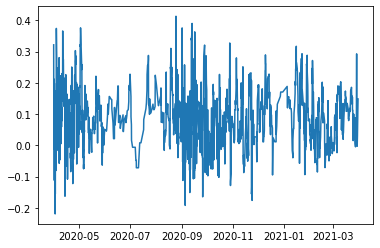

In [ ]:
from matplotlib import pyplot as plt
plt.plot(online['DateTime'], online['MA Polarity'])

Wordcloud

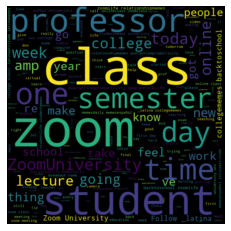

In [ ]:
all_words=' '.join( [twts for twts in tweets_df['Processed Tweet'] ])
wordCloud = WordCloud(width =500, height= 500, random_state=21, max_font_size=119).generate(all_words)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Conclusion**

After performing all the above sentiment analysis, we observe that people are positive towards both ‘lockdown’ and ‘vaccine’ but more positive about ‘vaccine’ than ‘lockdown’. However, the sentiments around these words have largely varied across time. 

We use the #covidworkfromhome to understand sentiments for remote working and observe that the sentiments for this word was initially very negative when it was first introduced, however, over time, the sentiments have become overall positive. For the #zoomuniversity (used to understand sentiments around online learning), the sentiments are overall positive but they have hugely varied over time. On an average, people are more positive about online learning than remote working. 